## Patriots & NFL Detection Using NLP and Classification Models

### Problem Statement

Patriots & NFL subreddits posts were gathered from [Reddit](#https://www.reddit.com/). This project attempts to detect Patriots posts from NFL posts using Natural Language Processing (NLP) and building classification models with data from both subreddits. As a fan of New England Patriots team i would like to see how Patriots posts are filtered from NFL posts.

### Data Gathering

I used Pushshift Api to scrape data from Patriots and NFL subreddits in order to create a classification model to detect posts from each subreddit.I scraped the following information:

   * subreddit: which subreddit the post belong to
   * title: title of particular subreddit post
   * author: author of the post
   * domain: domain referenced to the post
   * created_utc: date & time post created

In total i scrapped 39,989 posts from both subreddits: 19,993 from Patriots subreddit and 19,996 from NFL subreddit.

### Contents

- [Import Libraries](#Import-Libraries)
- [Import Data](#Import-Data)
    - [Investigate Data](#Investigate-Data)
    - [Cleaning Data](#Cleaning-Data)
- [Exploratory-Data-Analysis (EDA)](#Exploratory-Data-Analysis)
    - [Top Authors](#Top-Authors)
    - [Top Domains](#Top-Domains)
    - [Sentiment Analysis](#Sentiment-Analysis)
    - [Visualizing Sentiments](#Visualizing-Sentiments)
    - [Natural Language Processing (NLP)](#Natural-Language-Processing-(NLP))
    - [Republicans Top 10 Unigrams](#Republicans-Top-10-Unigrams)
    - [Conservatives Top 10 Unigrams](#Conservatives-Top-10-Unigrams)
    - [Republicans Top 10 Bigrams](#Republicans-Top-10-Bigrams)
    - [Conservatives Top 10 Bigrams](#Conservatives-Top-10-Bigrams)
    - [Common Unigrams](#Common-Unigrams)
    - [Common Bigrams](#Common-Bigrams)
- [Feature Engineering](#Feature-Engineering)
    - [Create Custom Stop Words](#Create-Custom-Stop-Words)
    - [Combine Subreddits](#Combine-Subreddits)
    - [Select Features & Target](#Select-Features-&-Target)
- [Build Model](#Build-Model)
    - [1.a Logistic Regression & CounterVectorizer](#1.a-Logistic-Regression-&-CounterVectorizer)
    - [1.b Logistic Regression & TfidVectorizer](#1.b-Logistic-Regression-&-TfidVectorizer)
    - [2.a Multinomial NB & CounterVectorizer](#2.a-Multinomial-NB-&-CounterVectorizer)
    - [2.b Multinomial NB & TfidVectorizer](#2.b-Multinomial-NB-&-TfidVectorizer)
- [Model Evaluation](#Model-Evaluation)
    - [Logistic Regression & CounterVectorizer](#Logistic-Regression-&-CounterVectorizer)
    - [Plot Confusion Matrix](#Plot-Confusion-Matrix)
    - [Coefficients Interpretability](#Coefficients-Interpretability)
- [Conclusions](#Conclusions)
    - [Disadvantages](#Disadvantages)

### Import Libraries

In [1]:
#Import all libraries i will need for the project

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix ,plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

import datetime
pd.options.display.max_colwidth = 200

import warnings
warnings.simplefilter("ignore")

### Import Data

In [142]:
#Import Patriots dataset and check the shape and first 5 rows

patriots = pd.read_csv('../data/patriots.csv')
patriots.head()

,subreddit,title,author,domain,timecreated
0,Patriots,Yo what did Edelman post on his story??? (Ignore the ad at the beginning),Patsct1203,/r/Patriots/comments/ttu70z/yo_what_did_edelman_post_on_his_story_ignore_the/,1648828738
1,Patriots,"[Highlights] Cris Collinsworth reacts to N'Keal Harry's Catch: ""That may be the greatest catch I've ever seen in my lifetime""",Lagooooooon,/r/Patriots/comments/tttw3w/highlights_cris_collinsworth_reacts_to_nkeal/,1648827990
2,Patriots,What if we did 28-3 here?,katybobaty,i.redd.it,1648827341
3,Patriots,Jules giving me an absolute heart attack,1337speak,twitter.com,1648825311
4,Patriots,Place?,Coppatop,self.Patriots,1648819178


In [143]:
#Import NFL datset and check the shape and first 5 rows

nfl = pd.read_csv('../data/nfl.csv')
nfl.head()

,subreddit,title,author,domain,timecreated
0,nfl,The DK Diet,Mrcounterpoint420,self.nfl,1648829092
1,nfl,"Random NFL Fact: In 1932, the Chicago Bears had 6 ties in a single season (including 3 scoreless ties in a row to start the year). Due to the Great Depression and financial losses, Hall of Fame Co...",TheFencingCoach,pro-football-reference.com,1648829039
2,nfl,[DIGGS] Me wanting to participate in April fools jokes…,sovinder,twitter.com,1648828988
3,nfl,Bricsys BricsCAD Catia 21.2 Crack Win/Mac Ultimate Torrent License Key Download 2022,kingkhan0200,imrankhansoftware.tk,1648828929
4,nfl,Is taking a hit from ray Lewis enough to knock someone out,Flat-Western-7921,self.nfl,1648828718


#### Investigate Data

In [144]:
#Checking for general info for patriots dataset
patriots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19993 entries, 0 to 19992
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19993 non-null  object
 1   title        19993 non-null  object
 2   author       19993 non-null  object
 3   domain       19993 non-null  object
 4   timecreated  19993 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 781.1+ KB


In [145]:
#Checking for general info for nfl dataset
nfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19996 non-null  object
 1   title        19996 non-null  object
 2   author       19996 non-null  object
 3   domain       19996 non-null  object
 4   timecreated  19996 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 781.2+ KB


The timecreated column whould be in datetime format not int64 for both datasets

In [6]:
#Checking patriots dataset for missing values

patriots.isnull().sum()

subreddit          0
title              0
author             0
num_comments       0
score              0
num_subscribers    0
domain             0
timecreated        0
dtype: int64

In [7]:
#Checking nfl dataset for missing values

nfl.isnull().sum()

subreddit          0
title              0
author             0
num_comments       0
score              0
num_subscribers    0
domain             0
timecreated        0
dtype: int64

In [8]:
#Check the patriots datset for duplicated posts (the same title)

patriots[patriots.duplicated(subset='title') == True].shape[0]

672

In [9]:
#Check the nfl datset for duplicated posts (the same title)

nfl[nfl.duplicated(subset='title') == True].shape[0]

1176

I have duplicates in both datasets but more in conservative dataset. I have to remove them in order to have a clean dataset.

#### Cleaning Data

In [10]:
#Create a fundtion to convert epoch unix time to datetime

def convert_time(df, col):
    new_values = []
    
    for row in df[col].values:
        new_values.append(datetime.datetime.fromtimestamp(row))
    df[col] = new_values
    return f'Now the new datatype for timecreated column is : {df[col].dtype}'

In [11]:
#Convert timecreated column for republicans and conservative datasets

convert_time(patriots, 'timecreated')
convert_time(nfl, 'timecreated')

'Now the new datatype for timecreated column is : datetime64[ns]'

In [12]:
#Check the datasets again to see the new timecreated column dtype

patriots.head()

,subreddit,title,author,num_comments,score,num_subscribers,domain,timecreated
0,Patriots,If you could have a Patriots roster from any year which year would it be?,femalefirefighter56,0,1,636599,self.Patriots,2022-03-28 19:45:35
1,Patriots,That rare moment when 3/28 and current events collide....,5_Frog_Margin,0,1,636596,i.redd.it,2022-03-28 19:18:32
2,Patriots,New Nickname Opportunity,Striking_Slice953,0,1,636592,self.Patriots,2022-03-28 19:03:26
3,Patriots,"[Matt Ryan] Suiting up for my first NBA regular season game tonight. No matter the twists and turns, highs and lows, it was all worth it. Let’s go! @celtics ☘️",Jatz55,0,1,636588,mobile.twitter.com,2022-03-28 18:17:09
4,Patriots,Pats Mock Draft,KJ1707,0,1,636586,self.Patriots,2022-03-28 18:07:04


In [13]:
#Check the datasets again to see the new timecreated column dtype

nfl.head()

,subreddit,title,author,num_comments,score,num_subscribers,domain,timecreated
0,nfl,NFL: All teams must add minority offensive coach,guenchy,0,1,2474504,espn.com,2022-03-28 20:43:47
1,nfl,Texans Sign Daesean Hamilton to 1-year Deal,Clydefrog57,1,1,2474495,twitter.com,2022-03-28 20:38:33
2,nfl,"Talk about overtime rules, let's talk about getting rid of the goal posts!",itbittitcommit,0,1,2474489,youtube.com,2022-03-28 20:36:40
3,nfl,who's the most hyped team going into this season?,Visible_Chocolate_69,0,1,2474482,self.nfl,2022-03-28 20:35:31
4,nfl,Who are the top 5 receivers going into 2022?,Little-Tower-6157,0,1,2474479,self.nfl,2022-03-28 20:32:01


In [14]:
#Check the shape for both datasets

print(f'Shape of Republicans dataset is: {patriots.shape}')
print(f'Shape of Conservative dataset is: {nfl.shape}')

Shape of Republicans dataset is: (19993, 8)
Shape of Conservative dataset is: (19996, 8)


In [15]:
#Drop the duplicates for both datasets

patriots.drop_duplicates(subset='title', inplace = True)
nfl.drop_duplicates(subset='title', inplace = True)

In [16]:
#Check the new shape for both datasets

print(f'Shape of Republicans dataset is: {patriots.shape}')
print(f'Shape of Conservative dataset is: {nfl.shape}')

Shape of Republicans dataset is: (19321, 8)
Shape of Conservative dataset is: (18820, 8)


In [17]:
#Create a funtion to clean the dataset 
def clean_title(df):
    
    # Transform all text to lowercase
    df['title'] = df['title'].str.lower()
    
    # Remove punctation
    df['title'] = df['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    df['title'] = df['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    df['title'] = df['title'].str.replace('  ',' ')

In [18]:
clean_title(patriots)

In [19]:
clean_title(nfl)

### Exploratory Data Analysis

In [109]:
#Create a funtion to plot bar charts
def plot_barh(df, col, title, color = 'blue'):
    
    plt.figure(figsize=(10,6))
    all_values = df[col].value_counts()
    values_over_100 = all_values[all_values.values > 100].sort_values(ascending = True)
    
    ax = values_over_100.plot(kind = 'barh', color = color)
    plt.title(title)
    plt.xlabel('Number of posts')
    plt.ylabel(col)
    
    #Code found and adapted from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    for i in ax.patches:
        ax.text(i.get_width(), i.get_y(), int(i.get_width()), fontsize = 10, weight = 'bold', color = 'gray')
    

#### Top Authors

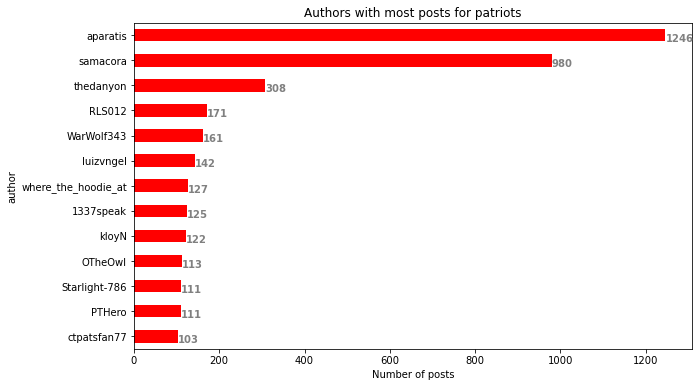

In [113]:
#Checking authors with most posts for patriots
valid_author_pats = patriots[patriots['author'] != '[deleted]']
plot_barh(valid_author_pats, 'author', 'Authors with most posts for patriots', 'r')
plt.savefig('patriot_author.png')

samacora looks the most active author for patriots subreddit with 877 posts 

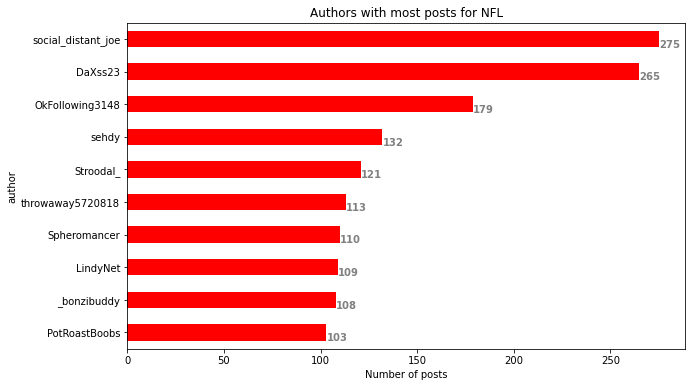

In [117]:
#Checking authors with most posts for nfl
valid_author_nfl = nfl[nfl['author'] != '[deleted]']
plot_barh(valid_author_nfl, 'author', 'Authors with most posts for NFL', 'r')
plt.savefig('nfl.png')

DaXss23 is the most active author for conservative subreddit with almost 154 posts

#### Top Domains

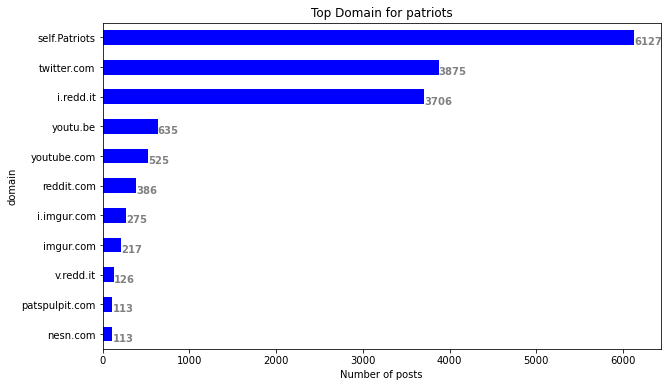

In [118]:
#Checking the top domains for patriots
plot_barh(patriots, 'domain', 'Top Domain for patriots')
plt.savefig('pats_domain.png')

self.Patriots looks the most referenced domain in patriots followed by i.redd.it and twitter.com

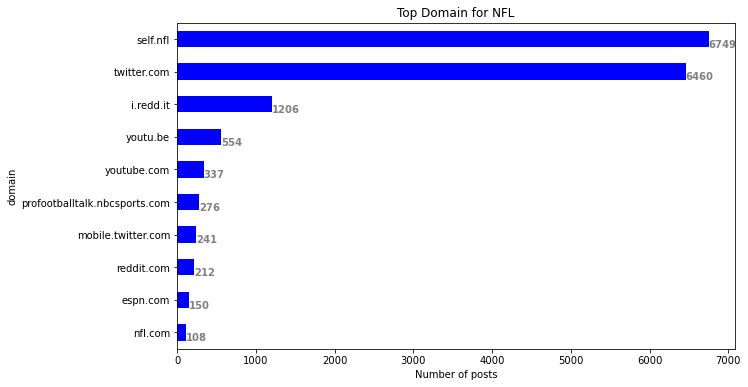

In [119]:
#Checking the top domains for nfl
plot_barh(nfl, 'domain', 'Top Domain for NFL')
plt.savefig('nfl_domain.png')

twitter followed by self.nfl are the most referenced domain in NFL subreddit

#### Sentiment Analysis

In [27]:
#Create a function to build a dataframe for sentiment analysis
def create_sentiment_df(df):
    
    #Instantiate SIA
    sia = SentimentIntensityAnalyzer()
    
    sentiment = []
    for title in list(df['title']):
        scores = sia.polarity_scores(title)
        sentiment.append(scores)
    
    df_sentiment = pd.DataFrame(sentiment)
    df_sentiment['title'] = df['title']
    df_sentiment['subreddit'] = df['subreddit']
    print('The sentiment dataframe was created successfully!')
    return df_sentiment

In [28]:
#Create the sentiment analysis dataset for patriots

df_patriots = create_sentiment_df(patriots)
df_patriots.head()

The sentiment dataframe was created successfully!


,neg,neu,pos,compound,title,subreddit
0,0.000,1.000,0.000,0.0000,if you could have a patriots roster from any year which year would it be,Patriots
1,0.157,0.843,0.000,-0.0772,that rare moment when and current events collide,Patriots
2,0.000,0.417,0.583,0.4215,new nickname opportunity,Patriots
3,0.125,0.781,0.094,-0.2500,matt ryan suiting up for my first nba regular season game tonight no matter the twists and turns highs and lows it was all worth it let s go celtics,Patriots
4,0.583,0.417,0.000,-0.4215,pats mock draft,Patriots


In [29]:
#Create the sentiment analysis dataset for nfl

df_nfl = create_sentiment_df(nfl)
df_nfl.head()

The sentiment dataframe was created successfully!


,neg,neu,pos,compound,title,subreddit
0,0.3,0.700,0.000,-0.4588,nfl all teams must add minority offensive coach,nfl
1,0.0,1.000,0.000,0.0000,texans sign daesean hamilton to year deal,nfl
2,0.0,1.000,0.000,0.0000,talk about overtime rules let s talk about getting rid of the goal posts,nfl
3,0.0,1.000,0.000,0.0000,who s the most hyped team going into this season,nfl
4,0.0,0.769,0.231,0.2023,who are the top receivers going into,nfl


#### Investigating Polarities Patriots

In [30]:
#Check for positive text for patriots

df_patriots.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,title,subreddit
7238,0.0,0.0,1.0,0.4215,hey tennessee,Patriots
8606,0.0,0.0,1.0,0.3400,lazar belichick stole a game wrecker on the d line in rookie christian barmore,Patriots
1684,0.0,0.0,1.0,0.2732,tom brady is to be an nfl head coach before the season bovada,Patriots
8311,0.0,0.0,1.0,0.6705,any word on the rbs,Patriots
3043,0.0,0.0,1.0,0.2960,it s simply time,Patriots
637,0.0,0.0,1.0,0.5859,i love mac jones,Patriots
12979,0.0,0.0,1.0,0.0772,visited la last week figured this sub would appreciate this billboard,Patriots
4862,0.0,0.0,1.0,0.2732,let s be optimistic but not cockey,Patriots
6939,0.0,0.0,1.0,0.6369,patriots rank heading into week,Patriots
7200,0.0,0.0,1.0,0.1280,i didn t know they gave r nfl commenters sports columns,Patriots


In [31]:
#Check for negative text for patriots

df_patriots.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,title,subreddit
8299,1.0,0.0,0.0,-0.5859,reiss practice squad moves c drake jackson and fb ben mason have been released opening two spots on the man unit could be clearing space for a possible rb with damien harris head rhamondre steve...,Patriots
14929,1.0,0.0,0.0,-0.4019,patriots running backs position overview,Patriots
9240,1.0,0.0,0.0,-0.5267,asked patriots cb jalen mills about how the pats coach up cbs he said the biggest help is bill belichick talking them through situational tendencies helps you anticipate routes third down two minu...,Patriots
8014,1.0,0.0,0.0,-0.2960,nfl matchup josh mcdaniels has schemed to the strengths of qb mac jones his accuracy and quick decision making allows him to thrive in the pass game,Patriots
6637,1.0,0.0,0.0,-0.3182,ray rauth j c jackson has averaged interceptions per game throughout the last four seasons,Patriots
11898,1.0,0.0,0.0,-0.4767,good pats bar in nyc to watch mac and the boys,Patriots
10356,1.0,0.0,0.0,-0.6705,i think steve may be signaling the defense with his tongue,Patriots
10755,1.0,0.0,0.0,-0.4404,patriots truly one helluva story thank you jules,Patriots
8622,1.0,0.0,0.0,-0.3182,football fans lmk,Patriots
11137,1.0,0.0,0.0,-0.8271,stop posting about the discord,Patriots


#### Investigating Polarities NFL

In [32]:
#Check for positive text for nfl

df_nfl.sort_values(by = 'pos', ascending = False).head(10)

,neg,neu,pos,compound,title,subreddit
11085,0.0,0.0,1.0,0.4215,petition to make the referees the mvp of the superbowl,nfl
4906,0.0,0.0,1.0,0.1779,steelers are extending chucks okorafor,nfl
6394,0.0,0.0,1.0,0.5994,name a player that you were disappointed about your team losing in free agency last year how do you feel about your team s decision now,nfl
1989,0.0,0.0,1.0,0.5267,glazer scoopage colts are trying to work out a trade right now with atlanta for qb matt ryan nflonfox not completed yet but trying to finalize,nfl
16344,0.0,0.0,1.0,0.5267,brady in i ve got another or years peyton has that s the final chapter game on the evidence was out there all along,nfl
12415,0.0,0.0,1.0,0.4019,pelissero the dolphins are interviewing chargers run game coordinator ol coach frank smith today for their offensive coordinator job source said smith has a strong history developing tight ends a...,nfl
10371,0.0,0.0,1.0,0.5267,s per bowl fly over,nfl
6361,0.0,0.0,1.0,0.2732,nflpa a look at each nfl club s cash spending for the season as of league wide spending is of the cap,nfl
5221,0.0,0.0,1.0,0.6249,packers agree to terms with preston smith on four year m extension za darius smith released,nfl
2369,0.0,0.0,1.0,0.4215,rapoport source robert woods to the titans,nfl


In [33]:
#Check for negative text for nfl

df_nfl.sort_values(by = 'neg', ascending = False).head(10)

,neg,neu,pos,compound,title,subreddit
11300,1.000,0.000,0.0,-0.1779,eli apple,nfl
16391,1.000,0.000,0.0,-0.5859,new england patriots it was quite the ride thank you and congratulations tombrady,nfl
11958,1.000,0.000,0.0,-0.4019,we are the super clio jury featuring gary vaynerchuck roxy young mark cuban amp more we re a panel of ad execs amp pop culture influencers selected by the clio awards to choose the most creative...,nfl
17361,1.000,0.000,0.0,-0.5106,will the rams have to use the visitor locker room in weeks,nfl
7003,1.000,0.000,0.0,-0.3612,schefter tagged so far ot orlando brown s jessie bates te david njoku te mike gesicki still expected to be tagged wr davante adams wr chris godwin mike williams dalton schultz,nfl
10495,1.000,0.000,0.0,-0.3612,pff highest graded players in the super bowl,nfl
7277,1.000,0.000,0.0,-0.4939,which team wins if there were x m relay competition among teams,nfl
16808,1.000,0.000,0.0,-0.4019,should the chiefs fire andy reid,nfl
9610,1.000,0.000,0.0,-0.5423,moo most pff war accumulated by non qbs in a season rams ers eagles ravens to be successful with the trade for a vet qb who isn t elite route you only need to have the best...,nfl
2497,0.861,0.139,0.0,-0.7351,schefter sacrebleu odell beckham a sign un contrat de ans et millions de dollars avec les commandents putain de merde,nfl


#### Visualizing Sentiments

In [34]:
#Combine both sentiments dataset
combine_sentiments = pd.concat([df_patriots, df_nfl]).reset_index(drop = True)

#Check both head and tail
combine_sentiments.head().append(combine_sentiments.tail())

,neg,neu,pos,compound,title,subreddit
0,0.000,1.000,0.000,0.0000,if you could have a patriots roster from any year which year would it be,Patriots
1,0.157,0.843,0.000,-0.0772,that rare moment when and current events collide,Patriots
2,0.000,0.417,0.583,0.4215,new nickname opportunity,Patriots
3,0.125,0.781,0.094,-0.2500,matt ryan suiting up for my first nba regular season game tonight no matter the twists and turns highs and lows it was all worth it let s go celtics,Patriots
4,0.583,0.417,0.000,-0.4215,pats mock draft,Patriots
38136,0.390,0.610,0.000,-0.4939,hof class with brady retiring,nfl
38137,0.000,1.000,0.000,0.0000,NaN,NaN
38138,0.375,0.625,0.000,-0.7650,who is the best qb in the nfc with brady retiring and rodgers possibly leaving,nfl
38139,0.000,1.000,0.000,0.0000,tom brady s accolades throughout his career,nfl
38140,0.000,0.903,0.097,0.1280,statmuse tom brady has won of all super bowls in history,nfl


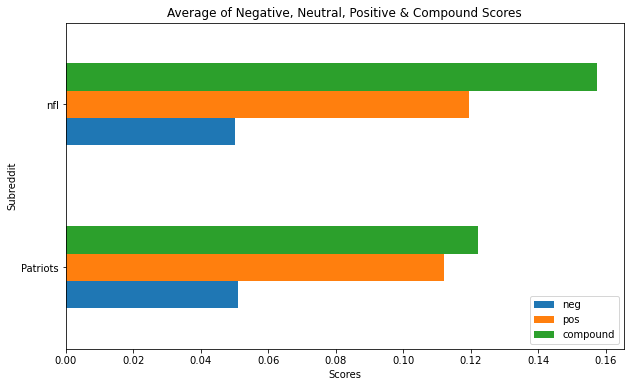

In [35]:
combine_sentiments.groupby('subreddit').mean()[['neg', 'pos', 'compound']].plot(kind = 'barh', figsize = (10,6))
plt.title('Average of Negative, Neutral, Positive & Compound Scores')
plt.xlabel('Scores')
plt.ylabel('Subreddit');

### Natural Language Processing (NLP)

In [36]:
#Create a funtion to get the unigrams
def get_unigrams(subreddit):
    #Instiate the CounterVectorizer for unigrams
    cvec = CountVectorizer(stop_words='english', ngram_range=(1, 1))
    
    #Fit transform 
    subreddit_cvec = cvec.fit_transform(subreddit['title'])
    #Convert to a dataframe
    subreddit_df = pd.DataFrame(subreddit_cvec.todense(), columns=cvec.get_feature_names())
    
    return subreddit_df


#Create a funtion to get the bigrams
def get_bigrams(subreddit):
    #Instiate the CounterVectorizer for bigrams
    cvec = CountVectorizer(stop_words='english', ngram_range=(2, 2))
    
    #Fit transform 
    subreddit_cvec = cvec.fit_transform(subreddit['title'])
    #Convert to a dataframe
    subreddit_df = pd.DataFrame(subreddit_cvec.todense(), columns=cvec.get_feature_names())
    
    return subreddit_df

In [37]:
#Create a funtion to plot unigrams and bigrams
def plot_uni_bi_grams(subreddit, title,  kind = ['unigram', 'bigram'], color = 'blue'):
    
    #Set the figure size
    plt.figure(figsize=(9,5))
    
    #Check the condition for grams
    if kind == 'unigram':
        unigrams = get_unigrams(subreddit) #Calling the funtion for getting unigrams into a dataframe
        #Select top 10 unigrams and Plot these to a barchart
        top_10_words = unigrams.sum().sort_values(ascending = False).head(10)
        ax = top_10_words.sort_values(ascending = True).plot(kind = 'barh', color = color)
        plt.title(title)
        plt.xlabel('Count of words')
        plt.ylabel('Unigrams')
        
    if kind == 'bigram':
        bigrams = get_bigrams(subreddit) # Calling the funtion for getting bigrams into a dataframe
        #Select top 10 bigrams andPlot these to a barchart
        top_10_words = bigrams.sum().sort_values(ascending = False).head(10)
        ax = top_10_words.sort_values(ascending = True).plot(kind = 'barh', color = color)
        plt.title(title)
        plt.xlabel('Count of words')
        plt.ylabel('Bigrams')
        
    
    #Count the times of word
    for i in ax.patches:
        ax.text(i.get_width(), i.get_y(), i.get_width())

#### Patriots Top 10 Unigrams

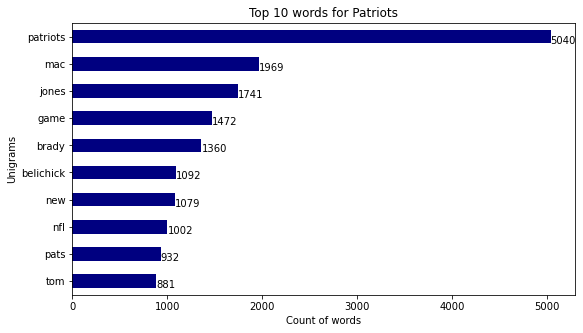

In [120]:
#Call the fuction to plot top 10 unigrams for Patriots
plot_uni_bi_grams(patriots, 'Top 10 words for Patriots',  'unigram', color = 'navy')
plt.savefig('pats_10_words.png')

Patriots, mac and jones are thre most used words in patriots subreddit

#### NFL Top 10 Unigrams

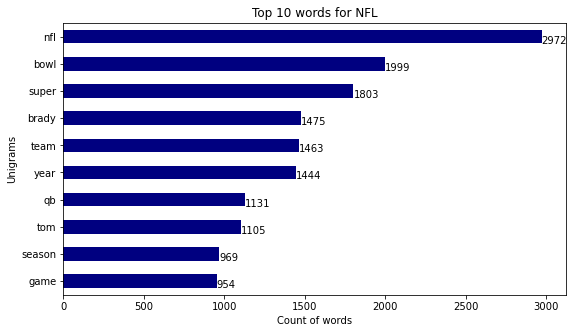

In [121]:
#Call the fuction to plot top 10 unigrams for nfl
plot_uni_bi_grams(nfl, 'Top 10 words for NFL',  'unigram', color = 'navy')
plt.savefig('nfl_10_words.png')

nfl, bowl and super words appears to be the most used words in posts for nfl.

#### Patriots Top 10 Bigrams

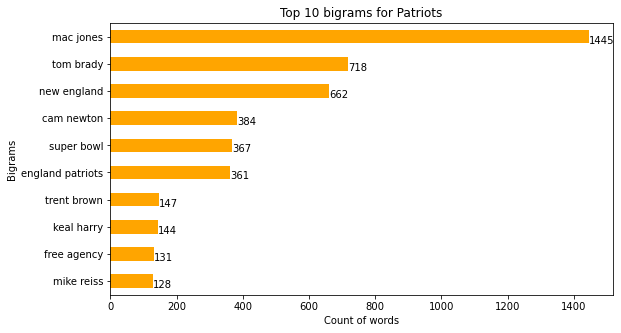

In [124]:
#Call the fuction to plot top 10 bigrams for Patriots
plot_uni_bi_grams(patriots, 'Top 10 bigrams for Patriots',  'bigram', color = 'orange')
plt.savefig('pats_bigram.png')

The most used biwords for patriots posts are "mac jones" followed by "tom brady" and "new england"

#### NFL Top 10 Bigrams

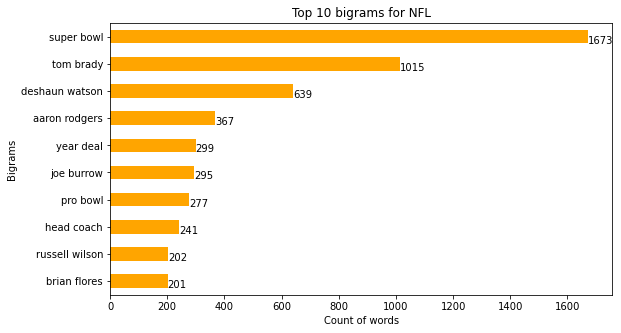

In [126]:
#Call the fuction to plot top 10 bigrams for nfl
plot_uni_bi_grams(nfl, 'Top 10 bigrams for NFL',  'bigram', color = 'orange')
plt.savefig('nfl_bigram.png')

The most used biwords for nfl posts are  "deshaun watson" followed "super bowl" and "year deal"

#### Common Unigrams

In [123]:
#Code adapted from https://stackoverflow.com/questions/60823145/intersect-bigram-trigram-in-python

#Select top 10 unigrams from patriots
patriots_top_uni = get_unigrams(patriots).sum().sort_values(ascending = False)[:10]
patriots_top_uni = patriots_top_uni.index

#Select top 10 unigrams from nfl
nfl_top_uni = get_unigrams(nfl).sum().sort_values(ascending = False)[:10]
nfl_top_uni = nfl_top_uni.index

#Apply intersection method to both datasets unigrams

unigrams_intersect = patriots_top_uni.intersection(nfl_top_uni)
unigrams_intersect

Index(['game', 'brady', 'nfl', 'tom'], dtype='object')

From unigrams these words appear at both subreddits. I will put to my custom stop words list.

#### Common Bigrams

In [127]:
#Select top 10 bigrams from patriots
patriots_top_bi = get_bigrams(patriots).sum().sort_values(ascending = False)[:10]
patriots_top_bi = patriots_top_bi.index

#Select top 10 bigrams from nfl
nfl_top_bi = get_bigrams(nfl).sum().sort_values(ascending = False)[:10]
nfl_top_bi = nfl_top_bi.index

#Apply intersection method to both datasets bigrams

bigrams_intersect = patriots_top_bi.intersection(nfl_top_bi)
bigrams_intersect

Index(['tom brady', 'super bowl'], dtype='object')

From bigrams these words appear at both subreddits. I will put to my custom stop words list.

### Feature Engineering

#### Create Custom Stop Words

In [44]:
#Create the custom stop words from unigrams and bigrams
my_stop_words = list(_stop_words.ENGLISH_STOP_WORDS)
#Append the unigrams_intersect
for word in unigrams_intersect:
    my_stop_words.append(word)
    
#Append the bigrams_instersect
for word in bigrams_intersect:
    my_stop_words.append(word)

#### Combine Subreddits

In [45]:
#Concanate the dataset
final_df = pd.concat([patriots, nfl]).reset_index(drop = True)

#Check the first 3 rows and last 3 rows of new dataset
final_df.head(3).append(final_df.tail(3))

,subreddit,title,author,num_comments,score,num_subscribers,domain,timecreated
0,Patriots,if you could have a patriots roster from any year which year would it be,femalefirefighter56,0,1,636599,self.Patriots,2022-03-28 19:45:35
1,Patriots,that rare moment when and current events collide,5_Frog_Margin,0,1,636596,i.redd.it,2022-03-28 19:18:32
2,Patriots,new nickname opportunity,Striking_Slice953,0,1,636592,self.Patriots,2022-03-28 19:03:26
38138,nfl,rob gronkowski says he d choose to retire if forced into decision right now,social_distant_joe,0,1,2365814,nfl.com,2022-01-26 11:41:45
38139,nfl,nwaneri cap i got my sources byron got the green light,hoyadestroyer,0,1,2365814,mobile.twitter.com,2022-01-26 11:41:02
38140,nfl,rosenthal the chiefs defense last games against non big ben teams points and yards allowed,WorldTwisting,0,1,2365797,twitter.com,2022-01-26 11:32:16


In [46]:
#Convert Patriots subreddit to 1 and nfl to 0

final_df['subreddit'] = final_df['subreddit'].apply(lambda x: 1 if x == 'Patriots' else 0)

#Check the first 3 rows and last 3 rows of updated subreddit column
final_df['subreddit'].head(3).append(final_df['subreddit'].tail(3))

0        1
1        1
2        1
38138    0
38139    0
38140    0
Name: subreddit, dtype: int64

#### Select Features & Target

In [47]:
#Select X and y to start building the model

X = final_df['title']
y = final_df['subreddit']

In [48]:
#Train test split the features and target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

### Modeling

In [49]:
#Check the baseline accuracy
final_df['subreddit'].value_counts(normalize = True)

1    0.506568
0    0.493432
Name: subreddit, dtype: float64

My target variable is very balanced so what i will try to do is to get a better score than 50%

#### 1. Logistic Regression

##### 1.a Logistic Regression Model & CounterVecotrizer

In [62]:
#Create a pipeline for logistic regression

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression(solver = 'liblinear'))
])

params = {
    'cvec__stop_words': [None, 'english', my_stop_words],
    'cvec__max_df': [0.75, 0.85],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1, 2), (1, 3)],
    'cvec__binary': [True, False],
    'cvec__lowercase': [True, False],
    'log__C': [0.35, 0.75, 1]
}

gs = GridSearchCV(pipe, params, cv = 5, n_jobs= - 1)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'Train Score: {gs.score(X_train, y_train)}')
print(f'Test Score: {gs.score(X_test, y_test)}')
gs.best_params_

Best Score: 0.8571927984618075
Train Score: 0.9507079181961196
Test Score: 0.8616820469798657


{'cvec__binary': True,
 'cvec__lowercase': True,
 'cvec__max_df': 0.75,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': None,
 'log__C': 0.35}

This models scores are telling me that this model is overfitting with a accuracy score in test set ~86.16%. Stop_words is choosed None as optimizing the model.

##### 1.b Logistic Regression & TfidVectorizer

In [71]:
#Create a pipeline
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('log', LogisticRegression(solver = 'liblinear'))
])

#Adding params to CounterVectorizer and Logistic Regression

params = {
    'tfid__stop_words': [None],
    'tfid__max_df': [0.75, 0.85],
    'tfid__min_df': [2, 3],
    'tfid__ngram_range': [(1, 2)],
    'tfid__binary': [True],
    'tfid__lowercase': [True],
    'log__C': [0.5, 1]
}

gs = GridSearchCV(pipe, params, n_jobs=-1, cv = 5)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print(f'The Train score: {gs.score(X_train, y_train)}')
print(f'The Test score: {gs.score(X_test, y_test)}')
gs.best_params_

Best Score: 0.8554448522985492
The Train score: 0.9195944764901242
The Test score: 0.8610528523489933


{'log__C': 1,
 'tfid__binary': True,
 'tfid__lowercase': True,
 'tfid__max_df': 0.75,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': None}

This model is also overfitting, less overfitting than logistic regression & CountVectorizer but little bit lower accuracy score(86.10%).

#### 2. Multinomial Naive Bayes

##### 2.a Multinomial NB & CounterVectorizer

In [79]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),    
    ('nb', MultinomialNB())
])

# Tune GridSearchCV
params = {
    'cvec__stop_words':[None, 'english'],
    'cvec__max_df':[0.75],
    'cvec__min_df': [2],
    'cvec__ngram_range': [(1, 2), (1, 3)],
    'cvec__binary': [True],
    'cvec__lowercase': [True],
    'nb__alpha': [1]
}


gs = GridSearchCV(pipe, params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best Score: 0.8469498339451146
Train score 0.9080929907358853
Test score 0.8539219798657718


{'cvec__binary': True,
 'cvec__lowercase': True,
 'cvec__max_df': 0.75,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'nb__alpha': 1}

The Naive Bayes with CounterVectorizer is overfitting less than logistic regression but with lower accuracy score.(85.39%)

##### 2.b Multinomial NB & TfidVectorizer

In [85]:
pipe = Pipeline([('tfid', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
params = {
    'tfid__stop_words': [None],
    'tfid__max_df': [.75],
    'tfid__min_df': [2],
    'tfid__ngram_range': [(1, 2), (1, 3)],
    'tfid__binary': [True],
    'tfid__lowercase': [True],
    'nb__alpha': [1]
}

gs = GridSearchCV(pipe, params, cv=5)
gs.fit(X_train, y_train)

print(f'Best Score: {gs.best_score_}')
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best Score: 0.846425450096137
Train score 0.9140360076909632
Test score 0.854236577181208


{'nb__alpha': 1,
 'tfid__binary': True,
 'tfid__lowercase': True,
 'tfid__max_df': 0.75,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': None}

The Naive Bayes & TfidVecotizer perform a little bit better than Naive Bayes & CounterVectorizer on accuracy score and just a little bit more overfitt 

### Model Evaluation

All 4 models are overfitting a little but what i'm looking is to get the highest accuracy score. The best accuracy score has Logistic Regression & CounterVectorizer. Also the Logistic Regression & CounterVecotizer is the best model for interpreting the coefficients as well.

##### Logistic Regression & CounterVectorizer

In [140]:
#Instatiate the model with countervectorizer
log = LogisticRegression(solver='liblinear', C = 0.35)
cvec = CountVectorizer(ngram_range=(1, 3), binary=True, lowercase=True, min_df=2, max_df=0.75)

#Fit Transform the data to be ready for modeling
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#Fit the model
log.fit(X_train_cvec, y_train)

#Get predictions from the model
preds = log.predict(X_test_cvec)

print(f'Accuracy score: {accuracy_score(y_test, preds)}')

Accuracy score: 0.8616820469798657


##### Plot Confusion Matrix

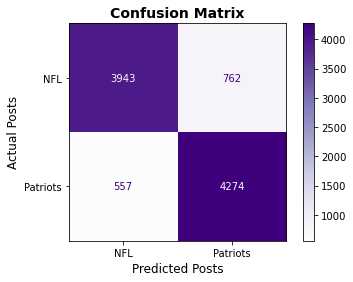

In [135]:
plot_confusion_matrix(log, X_test_cvec, y_test, cmap = 'Purples', display_labels=['NFL', 'Patriots'])
plt.title('Confusion Matrix', fontsize = 14, weight = 'bold')
plt.xlabel('Predicted Posts', fontsize = 12)
plt.ylabel('Actual Posts', fontsize = 12);
plt.savefig('conf_matrx.png')

In [88]:
#Calculate scores

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(f'Accuracy score: {round(accuracy_score(y_test, preds)* 100, 2)}%')
print(f'Precision score: {round(precision_score(y_test, preds)* 100, 2)}%')
print(f'Sensitivity score: {round(recall_score(y_test, preds)* 100, 2)}%')
print(f'Specificity score: {round((tn / (tn + fp)) * 100 ,2)}%')
print(f'Missclafication score: {round((1 - accuracy_score(y_test, preds)) * 100, 2)}%')

Accuracy score: 86.17%
Precision score: 84.87%
Sensitivity score: 88.47%
Specificity score: 83.8%
Missclafication score: 13.83%


##### Coefficients Interpretability

I have to create another counter vectorizer with  my custom stop words so the common words (also 'patriots', 'pats', or 'nfl') don't appear  to my coefficents

In [89]:
#Extend my custom stop words
words = ['patriots', 'pats', 'nfl']
for word in words:
    if word not in my_stop_words:
        my_stop_words.append(word)

In [90]:
log = LogisticRegression(solver='liblinear', C = 0.75)
cvec_2 = CountVectorizer(stop_words = my_stop_words)

X_train_cvec2 = cvec_2.fit_transform(X_train)
X_test_cvec_2 = cvec_2.transform(X_test)

log.fit(X_train_cvec2, y_train)

LogisticRegression(C=0.75, solver='liblinear')

The logic of selecting coeff for patriots posts and nfl posts: When the coeff is positive it means that particular word has more odds to be in patriots posts and when is negative it means it will have more odds the other class which is nfl.

In [91]:
#Get the coefficients from Logistic Regression
log_coeff = log.coef_.tolist()[0]

#Convert to a dataframe
coeff_df = pd.DataFrame(log_coeff, cvec_2.get_feature_names(), columns=['Coefficients'])

#Sorting the values from the most positive one to the most negative one
coeff_df = coeff_df.sort_values(by = 'Coefficients', ascending=False)

In [92]:
#The most positive will be for Patriots posts
patriots_coeff = coeff_df.head(15)

#The most negative correlation of patriots will be most positive for nfl
nfl_coeff = coeff_df.tail(15)

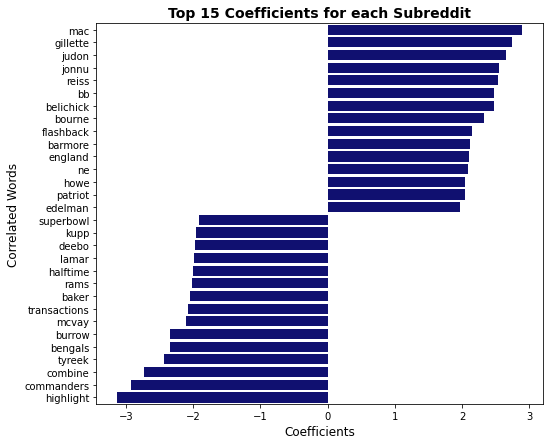

In [132]:
#Conconat those 2 dataframes to be able to plot coefficients in to a barplot
most_pos_neg_coeff_df = pd.concat([patriots_coeff, nfl_coeff])

plt.figure(figsize=(8, 7))
sns.barplot(x = most_pos_neg_coeff_df['Coefficients'], y = most_pos_neg_coeff_df.index, color = 'navy')
plt.title('Top 15 Coefficients for each Subreddit', fontsize = 14, weight = 'bold')
plt.xlabel('Coefficients', fontsize = 12)
plt.ylabel('Correlated Words', fontsize = 12)
plt.savefig('coeff.png')

For Patriots subreddit the most positively correlated word is "mac" followed by "gillette" and "judon" meanwhile for NFL subreddit the most positively correlated word is "highlight", "commanders" and "combine" 

In [94]:
#Interpret coefficients for Patriots subreddit. To be able to interpret the coefficients i have to exponential them. I will create a new column Coefficients Exp.
patriots_coeff['Coefficients_Exp'] = np.exp(patriots_coeff['Coefficients'])

#Check the new dataframe
patriots_coeff

,Coefficients,Coefficients_Exp
mac,2.899216,18.159907
gillette,2.748715,15.622539
judon,2.660343,14.301194
jonnu,2.553196,12.848094
reiss,2.533327,12.595345
bb,2.482267,11.968365
belichick,2.472723,11.854686
bourne,2.326653,10.243594
flashback,2.155433,8.631628
barmore,2.124100,8.365368


If the presence of word "mac" increased by 1 in title, that title is 18.16 as likely to be classified as Patriots subreddit.

In [95]:
#Interpret coefficients for NFL subreddit. To be able to interpret the coefficients i have to exponential them but first i have to take absolute value to convert to positive values. I will create a new column Coefficients Exp.
nfl_coeff['Coefficients_Exp'] = np.exp(abs(nfl_coeff['Coefficients']))

#Check the new dataframe sorted by exp 
nfl_coeff.sort_values(by = 'Coefficients_Exp', ascending=False)

,Coefficients,Coefficients_Exp
highlight,-3.137058,23.036004
commanders,-2.926874,18.669184
combine,-2.732294,15.368107
tyreek,-2.430514,11.364722
bengals,-2.347940,10.463988
burrow,-2.339433,10.375352
mcvay,-2.108851,8.238771
transactions,-2.078955,7.996108
baker,-2.045151,7.730327
rams,-2.019062,7.531258


Adding the presence of word 'highlight' by 1 in title, that title is 23 times as likely to be classified as NFL subreddits

### Conclusions

The best model to detect the patriots subreddit from NFL subreddit is Logistic Regression and using CounterVectorizer for vectorizing the data. The tuning hyperparameters are stop_words =  None, ngram_range = (1, 3) and C = 0.75

* Accuracy score: 86.17%
* Precision score: 84.87%
* Sensitivity score: 88.47%
* Specificity score: 83.8%
* Missclafication score: 13.83%

Also for interpreting the coefficients the Logistic Regression and CounterVectorizer i used.

* For Patriots subreddit the most positively correlated word is "mac" followed by "gillette" and "judon"
    * If the presence of word "mac" increased by 1 in title, that title is 18.16 as likely to be classified as Patriots subreddit.
    
* For NFL subreddit the most positively correlated word is "highlight", "commanders" and "combine" 
    * Adding the presence of word 'highlight' by 1 in title, that title is 23 times as likely to be classified as NFL subreddits

#### Disadvantages

For this project i built the classification model based just on title of the subreddits. I was interested for self text as well but most of the post were images and my model can't analyze images yet.